<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/1/MLP_Basics_ModelEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from matplotlib import rcParams
# rcParams['figure.figsize'] = 15,7
plt.rc('figure', figsize=(12,7) )         # Image size

import seaborn as sns

import io, requests

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


In [2]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 10 )

plt.rc('figure', figsize=(10,5) )         # Image size

In [3]:
def grid(x1, x2, off_set = .1, n_points = 100):
    ## d s show the range in the two varible. 
    d1 = x1.max() - x1.min()
    d2 = x2.max() - x2.min()
    
    x1_min, x1_max = x1.min() - off_set * d1 , x1.max() + off_set * d1
    x2_min, x2_max = x2.min() - off_set * d2 , x2.max() + off_set * d2

    ## This function from numpy gives a list of coordinates that are the points on the grid. 
    x, y = np.meshgrid(np.arange(x1_min, x1_max , d1/n_points), np.arange(x2_min, x2_max , d2/n_points) )

    return x , y 

# Good fit vs good model

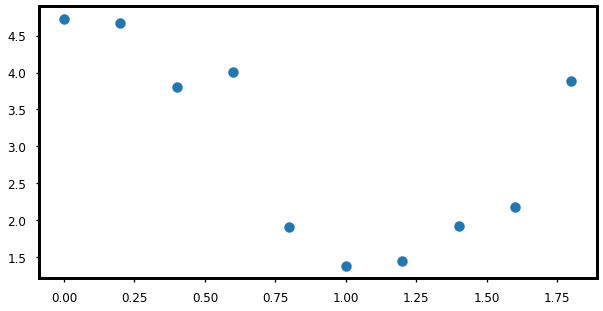

In [ ]:
'''
We first need some data. Let's make some.
'''
eps = .5  # The amplitude of the noise. 
w_real = np.array([3, -6, 1, 4])
pol_feature = lambda x, deg: np.hstack([x**(deg-d) for d in np.arange(deg+1) ])
func = lambda x, w: w @ pol_feature(x, 3)

x_list = np.arange(0,2,.2).reshape(-1,1)
y_list = [func(x, w_real) + np.random.normal(0,eps) for x in x_list]

plt.scatter(x_list, y_list);

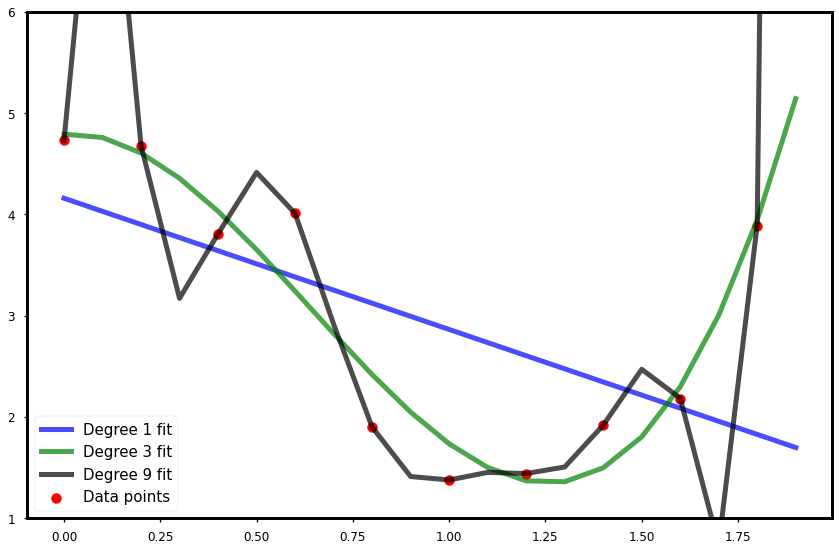

In [ ]:
x_range = np.arange(0,2,.1).reshape(-1,1)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1 )
ax.scatter(x_list, y_list, s = 100, c = 'r', label='Data points')

deg_list = [1,3,9]
col_list = ['b', 'g', 'black']
ind = -1
for deg in deg_list:
  ind +=1
    ## Make the X matrix with powers of the x
  x_rg_in = pol_feature(x_list, deg)

  ## Construct m as X^T.X
  m = np.dot(x_rg_in.T,x_rg_in)

  ## This gives the w
  w = np.dot(np.linalg.inv(m),np.dot(x_rg_in.T, y_list))  

  ## Add the plot
  y_rg_list = np.dot(pol_feature(x_range, deg), w)
  
  ax.plot(x_range, y_rg_list, alpha=.7, c = col_list[ind], label=f'Degree {deg} fit')
    

plt.ylim((1,6))
plt.legend()
plt.tight_layout()
plt.show()    

# Bias and Variance

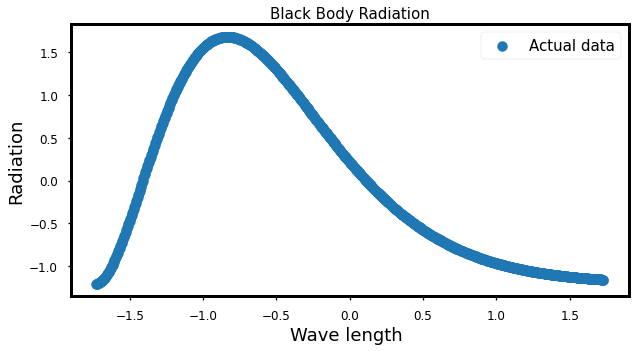

In [ ]:
#####BBR###### 
## This data is collected from galileo.phys.virginia.edu/classes/252
url = "https://github.com/sraeisi/MachineLearning_Physics/blob/master/Data/bbr.xls?raw=true"
data_bbr = pd.read_excel(url)


from sklearn.preprocessing import scale
# n_s_rate = 20

X_bbr = scale(data_bbr[0])
Y_bbr = scale(data_bbr['T'])

x_label = 'Wave length '
y_label = 'Radiation'
plt_title = 'Black Body Radiation'
fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
ax.scatter(X_bbr, Y_bbr, label = 'Actual data')

ax.legend()
plt.show()

## Model complexity

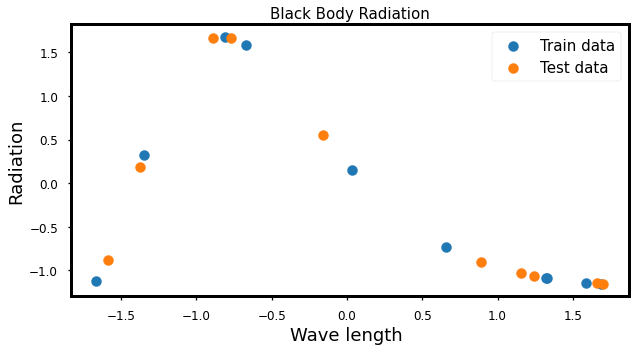

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, label = 'Test data')

ax.legend()
plt.show()

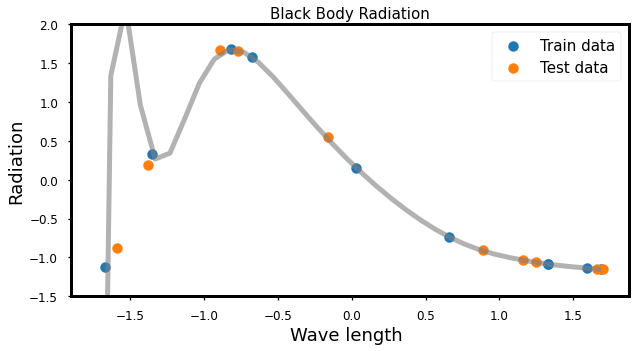

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
deg = 15
rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
rg.fit( X_train.reshape(-1,1), Y_train )

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)
y_range = rg.predict(x_range.reshape(-1,1) )


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, label = 'Test data')
ax.plot(x_range, y_range, c = 'gray', alpha = .6)

ax.legend()
# plt.yscale('log')
plt.ylim(-1.5,2)
plt.show()

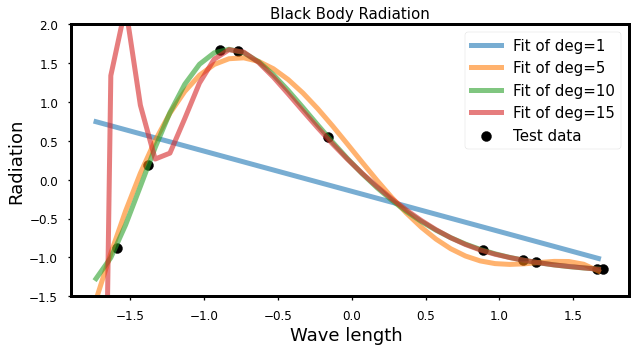

In [ ]:
deg_list = [1,5,  10, 15]


x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')
for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_range = rg.predict(x_range.reshape(-1,1) )

  ax.plot(x_range, y_range,  alpha = .6, label=f'Fit of deg={deg}')

ax.legend()
plt.ylim(-1.5,2)

plt.show()

### Validation Curve

How much complexity?

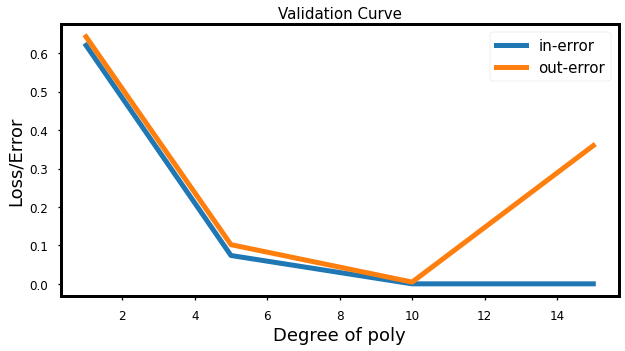

In [ ]:
in_err_list = []
out_err_list = []

for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_pred = rg.predict(X_train.reshape(-1,1) )
  in_err_list += [np.abs(Y_train-y_pred).sum()/len(Y_train) ]

  y_pred = rg.predict(X_test.reshape(-1,1) )
  out_err_list += [np.abs(Y_test-y_pred).sum()/len(Y_test) ]


in_err_list = np.array(in_err_list)
out_err_list = np.array(out_err_list)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Degree of poly', ylabel='Loss/Error', title='Validation Curve')

plt.plot(deg_list, in_err_list, label = 'in-error');
plt.plot(deg_list, out_err_list, label = 'out-error');

plt.legend()
# plt.yscale('log')
plt.show()

In [ ]:
# out_err_list- in_err_list
in_err_list

array([6.20532287e-01, 7.37640699e-02, 1.70141679e-15, 7.84400322e-14])

## Data

In [ ]:
ns = 200
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


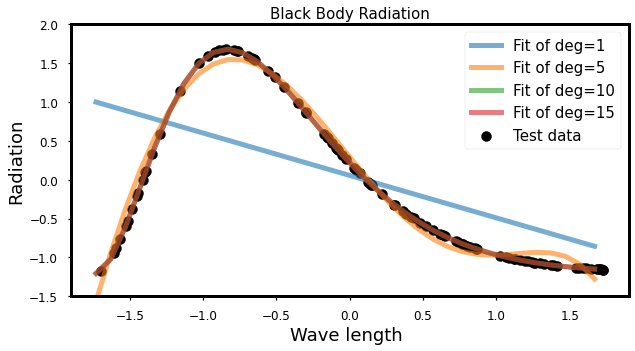

In [ ]:
deg_list = [1,5,  10, 15]


x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')
for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_range = rg.predict(x_range.reshape(-1,1) )

  ax.plot(x_range, y_range,  alpha = .6, label=f'Fit of deg={deg}')

ax.legend()
plt.ylim(-1.5,2)

plt.show()

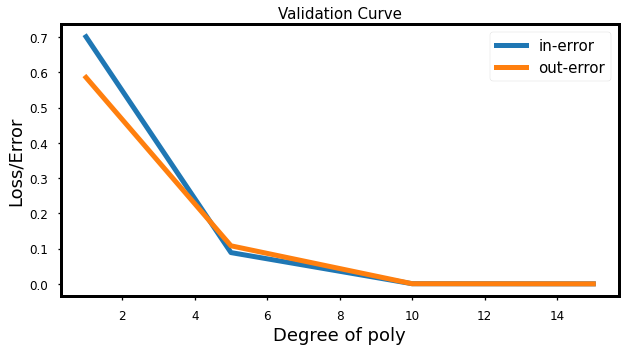

In [ ]:
in_err_list = []
out_err_list = []

for deg in deg_list:
  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_pred = rg.predict(X_train.reshape(-1,1) )
  in_err_list += [np.abs(Y_train-y_pred).sum()/len(Y_train) ]

  y_pred = rg.predict(X_test.reshape(-1,1) )
  out_err_list += [np.abs(Y_test-y_pred).sum()/len(Y_test) ]


in_err_list = np.array(in_err_list)
out_err_list = np.array(out_err_list)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Degree of poly', ylabel='Loss/Error', title='Validation Curve')

plt.plot(deg_list, in_err_list, label = 'in-error');
plt.plot(deg_list, out_err_list, label = 'out-error');
plt.legend()
# plt.yscale('log')
plt.show()

In [ ]:
out_err_list-in_err_list

array([-1.15343510e-01,  1.92401941e-02,  5.07460486e-05,  2.64677726e-07])

### Learning curve

How can we check if we have enough data?

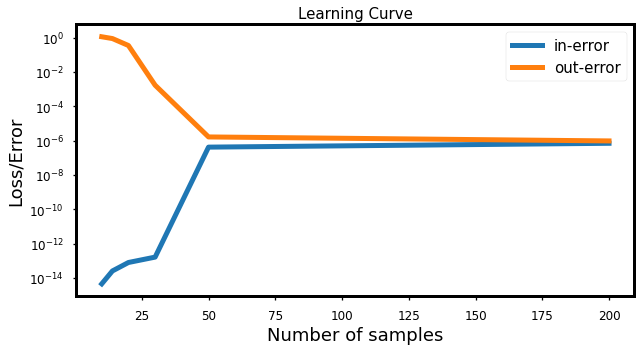

In [ ]:
deg = 15
ns_list = [ 10, 14, 20, 30, 50,  200]

in_err_list = []
out_err_list = []

for ns in ns_list:
  X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), ('model', LinearRegression() )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  y_pred = rg.predict(X_train.reshape(-1,1) )
  in_err_list += [np.abs(Y_train-y_pred).sum()/len(Y_train) ]

  y_pred = rg.predict(X_test.reshape(-1,1) )
  out_err_list += [np.abs(Y_test-y_pred).sum()/len(Y_test) ]


in_err_list = np.array(in_err_list)
out_err_list = np.array(out_err_list)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Number of samples', ylabel='Loss/Error', title='Learning Curve')

plt.plot(ns_list, in_err_list, label = 'in-error');
plt.plot(ns_list, out_err_list, label = 'out-error');
plt.legend()
plt.yscale('log')
plt.show()

## Regularization

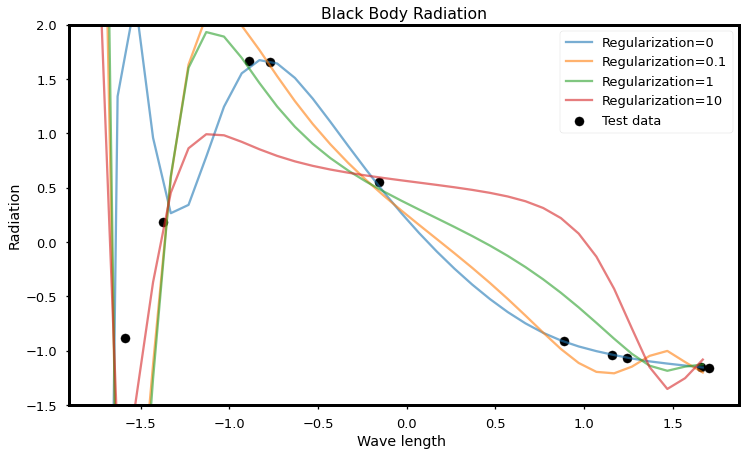

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# deg_list 
deg = 15
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


w_list = []

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')


r_list = [0,.1,1,10]

for r in r_list:

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
                ('model', Ridge( alpha=r ) ### We are using Ridge which uses l2 regularization. 
                )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  ### Let's store the weights
  w_list += [rg[1].coef_]

  y_range = rg.predict(x_range.reshape(-1,1) )
  ax.plot(x_range, y_range,  alpha = .6, label=f'Regularization={r}')


w_list = np.array(w_list)
plt.ylim(-1.5,2)
ax.legend()
plt.show()

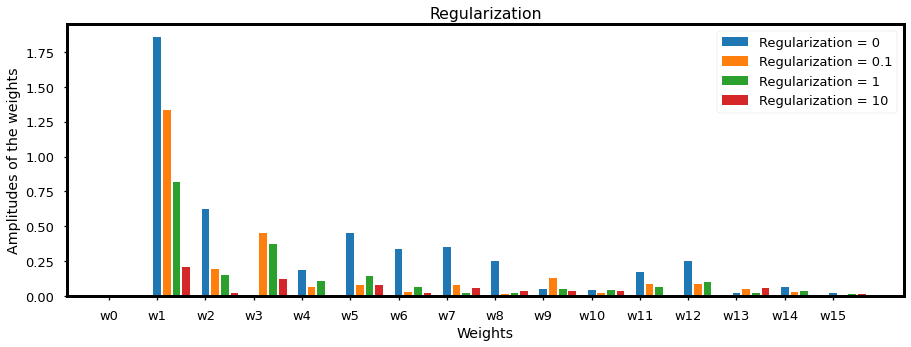

In [ ]:
# w_list.shape
x_ticks = np.arange(0,(deg+1)*(len(r_list)+1), 1 + len(r_list))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, xlabel='Weights', ylabel='Amplitudes of the weights', title='Regularization')
for i in range(len(r_list)):
  ax.bar(x_ticks+i, np.abs(w_list)[i], label=f'Regularization = {r_list[i]}')

plt.legend()
plt.xticks( (len(r_list)+1)*np.arange( len(w_list[0]) ) , labels= [f'w{i}' for i in np.arange(0, deg+1,1)])
plt.show()

### L1 vs L2 regularization

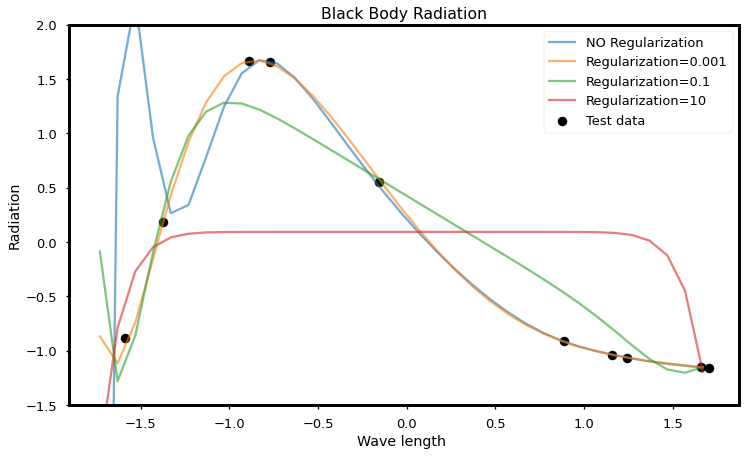

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso


deg = 15
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


w_list_lasso = []

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')


rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
              ('model', LinearRegression( ) ### We are using Ridge which uses l2 regularization. 
              )])
rg.fit( X_train.reshape(-1,1), Y_train )

### Let's store the weights
w_list_lasso += [rg[1].coef_]

y_range = rg.predict(x_range.reshape(-1,1) )
ax.plot(x_range, y_range,  alpha = .6, label=f'NO Regularization')


r_list = [.001,.1, 10]
for r in r_list:

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
                ('model', Lasso( alpha=r ) ### We are using Ridge which uses l2 regularization. 
                )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  ### Let's store the weights
  w_list_lasso += [rg[1].coef_]

  y_range = rg.predict(x_range.reshape(-1,1) )
  ax.plot(x_range, y_range,  alpha = .6, label=f'Regularization={r}')


w_list_lasso = np.array(w_list_lasso)
plt.ylim(-1.5,2)
ax.legend()
plt.show()

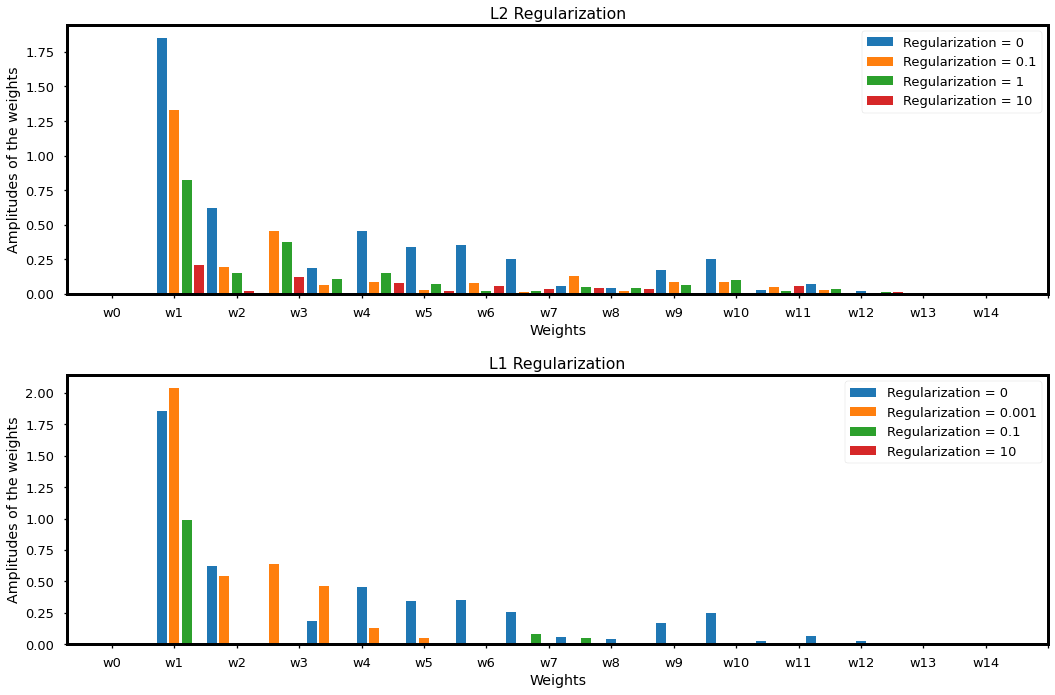

In [ ]:
# w_list.shape
x_ticks = np.arange(0,( deg+1 )*(len(r_list)+1), 1 + len(r_list))
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211, xlabel='Weights', ylabel='Amplitudes of the weights', title='L2 Regularization')
r_list = [0, .1, 1, 10]
for i in range(len(r_list)):
  ax.bar(x_ticks+i, np.abs(w_list)[i], label=f'Regularization = {r_list[i]}')

plt.legend()
plt.xticks( (len(r_list)+1)*np.arange( len(w_list[0]) ) , labels= [f'w{i}' for i in np.arange(0, deg,1)])

ax = fig.add_subplot(212, xlabel='Weights', ylabel='Amplitudes of the weights', title='L1 Regularization')

r_list = [0, .001,.1, 10]
for i in range(len(r_list)):
  ax.bar(x_ticks+i, np.abs(w_list_lasso)[i], label=f'Regularization = {r_list[i]}')

plt.legend()
plt.xticks( (len(r_list)+1)*np.arange( len(w_list[0]) ) , labels= [f'w{i}' for i in np.arange(0, deg,1)])

plt.tight_layout()
plt.show()

#### Noise

In [ ]:
noise = np.random.normal(0, .1, Y_bbr.shape)
Y = Y_bbr + noise

X_train, X_test, Y_train, Y_test = train_test_split(X_bbr.reshape(-1,1), Y, random_state = 0, shuffle=True)

This is the result of training with 12 points.



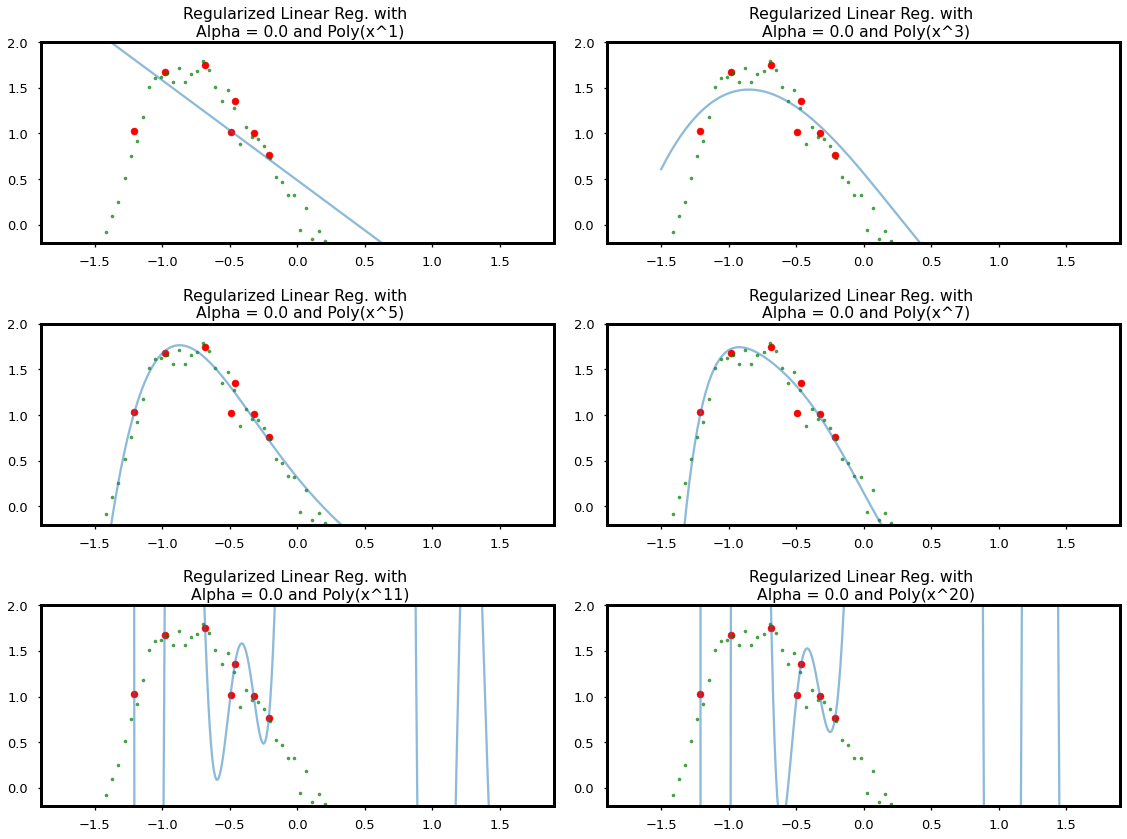

In [ ]:
n_rate = 50   #We only keep a subset of the points, every n_rate points. 
print(f'This is the result of training with {len(X_train[::n_rate])} points.\n')


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
##Let's have a regularization parameter. 

a = .00
reg = Ridge(alpha = a)

## It is convenient to make pipelines to get all the different pieces together.
from sklearn.pipeline import Pipeline


# for the plot
x_range = np.arange(-1.5,1.5,.01).reshape(-1,1)

fig = plt.figure(figsize=(16,12))

deg_list = [1,3,5,7,  11, 20]
ind = 0
for deg in deg_list:
    ind +=1

    ## Bulding the model anf training it.
    polynomial_features = PolynomialFeatures(degree=deg)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", reg)])
    pipeline.fit(X_train[::n_rate], Y_train[::n_rate])


    ## Generating a plot based on the predictions of the model. 
    y_rg_list = pipeline.predict(x_range)
    
    ax = fig.add_subplot(3, 2, ind ,  title = f'Regularized Linear Reg. with \n Alpha = {a} and Poly(x^{deg})')
    ax.scatter(X_train[::n_rate], Y_train[::n_rate], s = 50, c = 'r')
    ax.scatter(X_bbr[::10], Y[::10], s = 10, c = 'g', alpha=.7)
    ax.set_ylim(-.2, 2 )
    ax.plot(x_range, y_rg_list, alpha =.5)

plt.tight_layout()
plt.show()

Check and see how regularization work in this example!

# Classification exercise 

In [109]:
### Data
########Particles#######
# Data taken from https://www.kaggle.com/naharrison/particle-identification-from-detector-responses
ns = 2000

url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data_prtcl=pd.read_csv(io.BytesIO(s) , compression='zip' , usecols=['p', 'beta', 'id'])
data_prtcl = data_prtcl.sample(ns, random_state=0)
data_prtcl.id = data_prtcl.id.astype('category').cat.codes 

from collections import Counter
Counter(data_prtcl.id)

Counter({0: 6, 1: 1118, 2: 88, 3: 788})

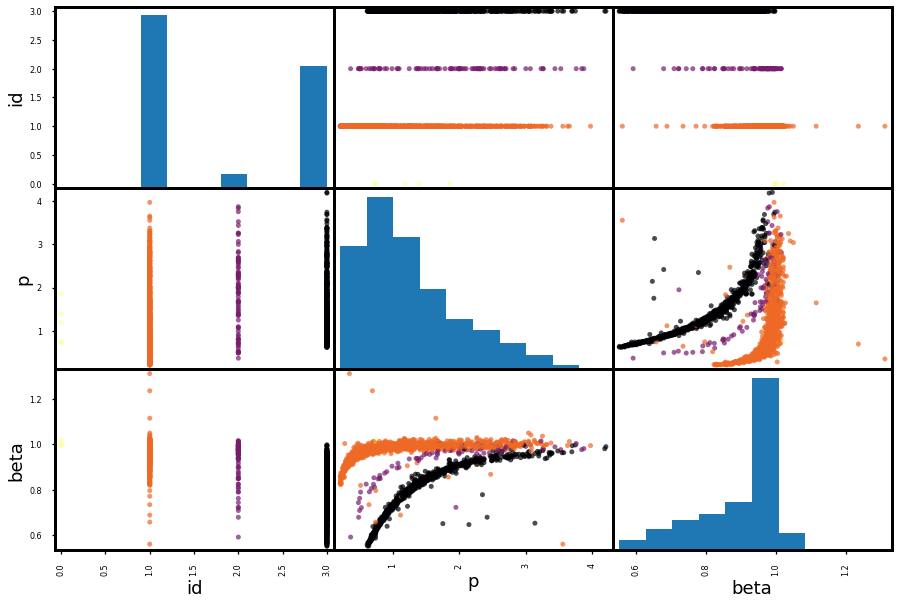

In [110]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, xlabel = 'p', ylabel='beta')
pd.plotting.scatter_matrix(data_prtcl, cmap=plt.cm.inferno_r , alpha=.7, c = data_prtcl.id, ax = ax)

plt.show()

Here are the label populations:
 Counter({-1: 1118, 1: 788}).


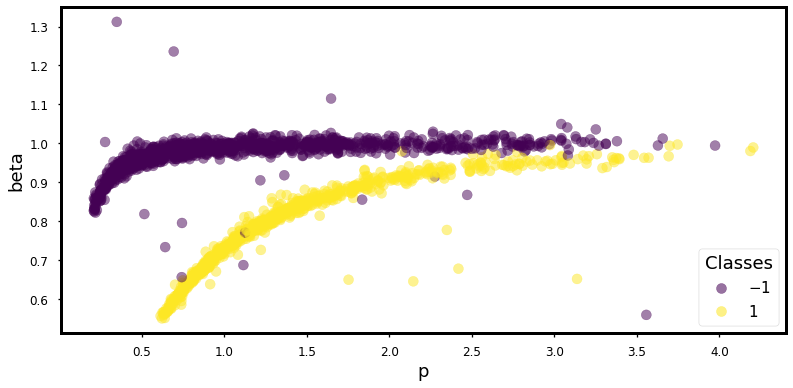

In [111]:
'''
Here we want to turn the problem into a binary 
classification. So we only keep two of the labels, 
i.e. labels_to_keep. 

We also keep only two features to make the classification 
easy to visualize. That would be to_keep_features. 

'''

labels_to_keep = [1,3]
# labels_to_keep = [2,3]
features_names = ['p','beta']

Y_prt = data_prtcl.id.values
X_prt = data_prtcl[features_names].values.reshape(-1,len(features_names))

ind_to_keep = np.any(np.vstack( [Y_prt==i for i in labels_to_keep] ), axis=0)

Y_prt = Y_prt[ind_to_keep]-2
X_prt = X_prt[ind_to_keep]

from sklearn.model_selection import train_test_split
X_train_prt, X_test_prt, Y_train_prt, Y_test_prt = train_test_split(X_prt , Y_prt, random_state=0)

from collections import Counter
print(f'Here are the label populations:\n {Counter(Y_prt)}.')



###Plotting

x1_list, x2_list = grid(*X_prt.T, n_points=70)
X_grid = np.vstack([x1_list.reshape(-1),x2_list.reshape(-1)]).T


fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, xlabel = 'p', ylabel='beta')
p = ax.scatter(*X_prt.T, c= Y_prt, alpha=0.5)

lgnd = ax.legend(*p.legend_elements(),
                    loc=4, title="Classes")
ax.add_artist(lgnd)
plt.show()

In [112]:
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [123]:
ns_list = np.array([ 3, 5, 10, 20 , 30 , 50, 76])
ncv = 5
## Here's how you can use the function implemented in sklearn for this. 
## But note that this works with scores instead of loss. 

ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = SVC( ), 
                                                   X = X_train_prt, y = Y_train_prt, 
                                                   train_sizes = ns_list, 
                                                   cv = ncv,
                                                   scoring = 'accuracy', 
                                                   n_jobs= -1
                                                   )

In [124]:
validation_scores.shape

(7, 5)

In [125]:
print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(ncv)], index=ns_list) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(validation_scores, columns=[f'cv{i+1}' for i in range(ncv)], index=ns_list) )

Training scores:

          cv1       cv2       cv3       cv4       cv5
3        NaN  1.000000  1.000000  1.000000  1.000000
5        NaN  1.000000  1.000000  1.000000  1.000000
10  0.800000  1.000000  1.000000  1.000000  1.000000
20  0.850000  0.900000  0.900000  0.900000  0.900000
30  0.900000  0.833333  0.833333  0.833333  0.833333
50  0.940000  0.840000  0.840000  0.840000  0.840000
76  0.973684  0.934211  0.934211  0.934211  0.934211

 ----------------------------------------------------------------------

Validation scores:

          cv1       cv2       cv3       cv4       cv5
3        NaN  0.573427  0.580420  0.611888  0.596491
5        NaN  0.622378  0.657343  0.646853  0.624561
10  0.587413  0.611888  0.618881  0.650350  0.628070
20  0.772727  0.779720  0.783217  0.790210  0.761404
30  0.811189  0.797203  0.790210  0.832168  0.814035
50  0.905594  0.814685  0.793706  0.832168  0.835088
76  0.902098  0.884615  0.870629  0.867133  0.873684


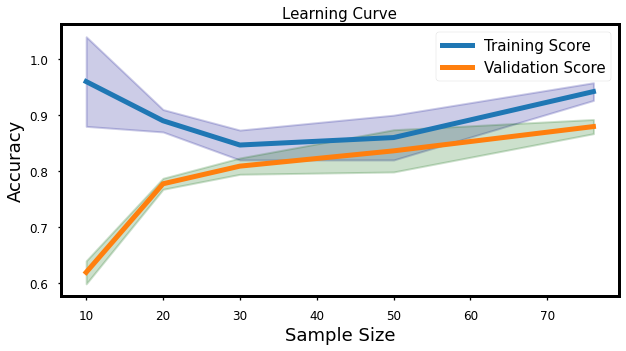

In [126]:
train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  validation_scores.mean(axis = 1)
validation_scores_std  = validation_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = 'Accuracy'

plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')

plt.fill_between(ns_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(ns_list, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)


ax.legend(loc=0)
plt.show()

In [ ]:
k_list = [1,3,5,7,10, 15, 20, 25, 30, 40, 50 , 75,  100, 125, 150, 175, 200]

train_scores, valid_scores = validation_curve(KNeighborsRegressor(),  X_train_prt, Y_train_prt, 
                                              param_name="n_neighbors",
                                              param_range=k_list , cv=20, 
                                              scoring = 'neg_mean_squared_error',
                                              verbose=1, n_jobs=-1
                                             )

train_scores_mean = - np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = - np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


xlabel = '# Neighbours, k'
ylabel = 'L2-loss score'

plt_title = 'Validation curve for regression with KNN'#.format(k)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.semilogx(k_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(k_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.semilogx(k_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(k_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

In [ ]:
# c_list = [.001, .01, .1, 1]
deg_list = [1,2, 3, 5, 10, 15]
train_scores, valid_scores = validation_curve(SVC(kernel='poly'), X_train_prt, Y_train_prt, 
                                              param_name="degree",
                                              param_range=deg_list , 
                                              cv=5, 
                                              scoring = 'accuracy',
                                              verbose=1, 
                                              n_jobs=-1
                                             )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
valid_scores

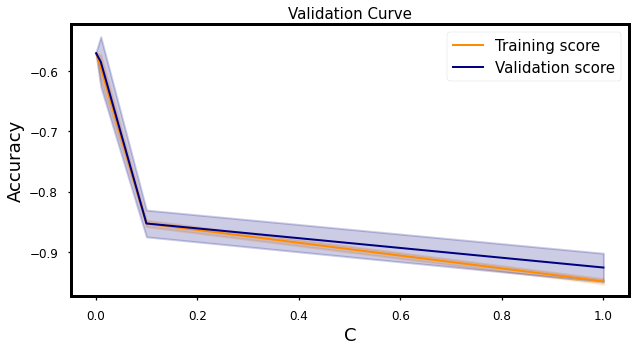

In [54]:
train_scores_mean = - np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = - np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


xlabel = 'C'
ylabel = 'Accuracy'

plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(c_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(c_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(c_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(c_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

# Recap

In [ ]:
url = 'https://raw.githubusercontent.com/sraeisi/Machine_Learning_Physics_Winter20/master/Lec1/particle_mini.npz'
s=requests.get(url, stream=True).content
data=np.load(io.BytesIO(s) )
X, Y = data['X'], data['Y']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X , Y, random_state=0)


from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Training the model
clf_pipeline= Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = 3)), 
                        ('clf', SGDClassifier())])
clf_pipeline.fit(X_train,Y_train)

### Testing the model
y_predict = clf_pipeline.predict(X_test)
out_error = np.abs(Y_test - y_predict).sum() / len(Y_test)

in_error = np.abs(Y_train - clf_pipeline.predict(X_train)  ).sum() / len(Y_train)

print(f'The in-sample error is {in_error:.4f}, and the out_sample error is {out_error:.4f}.')

The in-sample error is 0.0316, and the out_sample error is 0.0357.


In [ ]:
from joblib import dump, load
dump(clf_pipeline, 'pipeline')

['pipeline']

In [ ]:
model = load('pipeline')
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

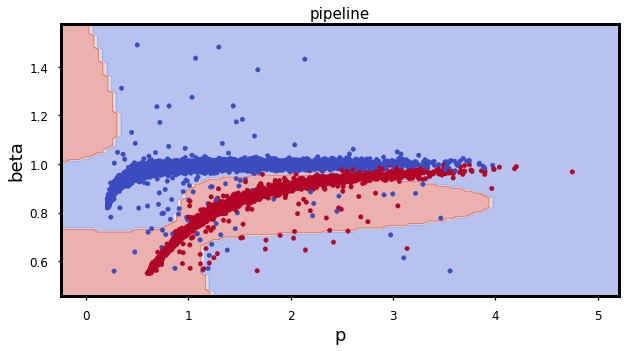

In [ ]:
x1_list, x2_list = grid(X[:,0], X[:,1], n_points=100)
X_grid = np.vstack([x1_list.reshape(-1),x2_list.reshape(-1)]).T

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1 , xlabel = 'p', ylabel='beta', title = 'pipeline')
Y_grid = model.predict( X_grid ).reshape(x1_list.shape )

ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)
ax.scatter(*X.T, c=Y, cmap=plt.cm.coolwarm, s=20)    
plt.show()